# lib imports

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score

import numpy as np
import os
import sys

ModuleNotFoundError: ignored

# Feature Selection

## training testing sets

In [ ]:
raw = pd.read_csv('cleaned_listings.csv')
df = raw[~raw['price'].isin([999, 9999])]
categorical_cols = ['host_response_time', 'neighbourhood_cleansed', 'property_type', 'room_type']  # add more if needed
for col in categorical_cols:
    df[col] = df[col].astype('category')

X = df.drop(columns=['id','source','name','host_id','host_name','host_is_superhost'])
y = df['host_is_superhost']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [ ]:
y.value_counts()

0    13545
1    12242
Name: host_is_superhost, dtype: int64

In [ ]:
print(len(X_train),len(X_test))

20629 5158


## Use XGBoost Classifier to Select Top20 Features

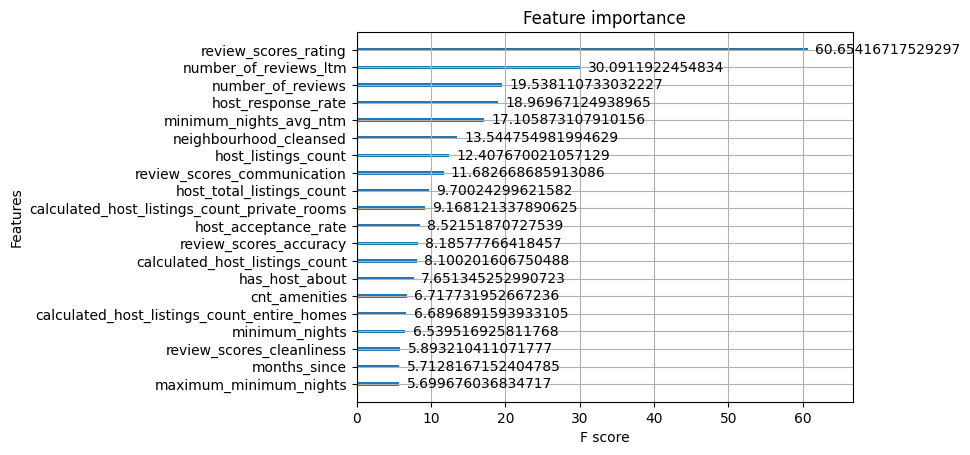

In [ ]:
# during

# Train XGBoost model
# Supported tree methods are `approx` and `hist`for categorical data.

model = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)
model.fit(X_train, y_train)

# Get feature importances
xgb_importances = model.feature_importances_

# Plot
xgb.plot_importance(model, max_num_features=20,importance_type='gain')
plt.show()

# Get the top 20 feature indices
sorted_idx = np.argsort(xgb_importances)[::-1]
top_20_features = sorted_idx[:20]

## SHAP Value not compatible with xgboost

In [ ]:

# Initialize JavaScript visualization code for SHAP
'''shap.initjs()

# Explain the model's predictions using SHAP
model.save_model("xgb_clf.json")
model_shap = xgb.Booster()
model_shap.load_model("xgb_clf.json")


explainer = shap.TreeExplainer(model_shap)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)
'''





'shap.initjs()\n\n# Explain the model\'s predictions using SHAP\nmodel.save_model("xgb_clf.json")\nmodel_shap = xgb.Booster()\nmodel_shap.load_model("xgb_clf.json")\n\n\nexplainer = shap.TreeExplainer(model_shap)\nshap_values = explainer.shap_values(X_test)\n\nshap.summary_plot(shap_values, X_test)\n'

# Use the Selected Feautures in different models

In [ ]:
# Create a k-fold cross-validator object (e.g., 5-fold)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Keep only top20 features in the original dataset
X = X.iloc[:, top_20_features]

## XGBoost hist tree

In [ ]:
# Initialize the model
model_xgb = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)

# Compute cross-validated accuracy scores
cv_scores = cross_val_score(model_xgb, X, y, cv=kf, scoring='accuracy')

# Print results
print('XGBoost hist tree')
print(f"Accuracy scores for the 5 folds: {cv_scores}")
print(f"Mean accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard deviation: {np.std(cv_scores):.4f}")


XGBoost hist tree
Accuracy scores for the 5 folds: [0.87029857 0.86041101 0.86038394 0.86290479 0.8596083 ]
Mean accuracy: 0.8627
Standard deviation: 0.0039


In [ ]:

def cv_score(X, y):
    return cross_val_score(model, X, y, cv=kf, scoring='accuracy').mean()
remaining_features = list(X.columns)
best_score = cv_score(X[remaining_features], y)
eliminated_features = []

while len(remaining_features) > 3:  # assuming you want at least one feature
    scores_with_dropped = []

    for feature in remaining_features:
        score = cv_score(X[remaining_features].drop(feature, axis=1), y)
        scores_with_dropped.append((feature, score))

    # Find the feature whose removal gives the best score
    feature_to_remove, best_score_with_dropped = max(scores_with_dropped, key=lambda x: x[1])

    if best_score_with_dropped > best_score:
        # Remove the feature and update the best score
        remaining_features.remove(feature_to_remove)
        eliminated_features.append(feature_to_remove)
        best_score = best_score_with_dropped
    else:
        # If removing any feature does not improve the score, break the loop
        break

print(f"Selected features: {remaining_features}")
print(f"Eliminated features: {eliminated_features}")
print(f"Best cross-validated score: {best_score:.4f}")



Selected features: ['review_scores_rating', 'number_of_reviews_ltm', 'number_of_reviews', 'host_response_rate', 'minimum_nights_avg_ntm', 'neighbourhood_cleansed', 'host_listings_count', 'review_scores_communication', 'host_total_listings_count', 'calculated_host_listings_count_private_rooms', 'host_acceptance_rate', 'review_scores_accuracy', 'calculated_host_listings_count', 'has_host_about', 'cnt_amenities', 'calculated_host_listings_count_entire_homes', 'minimum_nights', 'review_scores_cleanliness', 'months_since', 'maximum_minimum_nights']
Eliminated features: []
Best cross-validated score: 0.8627


https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7